# p4679 Lorenz Maps
## Imports and set directories

In [10]:
# Imports
import sys
from utils.paths import MAIN_DIRECTORY, REL_DATA_DIR
if MAIN_DIRECTORY not in sys.path:
    sys.path.append(MAIN_DIRECTORY)

# Import relevant libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch

# Import local modules - note: dependent on above path being set.
from utils.dataset import SlowEarthquakeDataset
from utils.general_functions import set_seed, set_torch_device
from utils.data_preprocessing import moving_average_causal_filter, create_dataset, split_train_test_forecast_windows, normalise_dataset
from utils.plotting import plot_example_sample,  plot_single_seg_result
from utils.nn_train import train_model, eval_model_on_test_set
from scripts.models.tcn_oneshot_multistep import MultiStepTCN
import scripts.models.lstm_oneshot_multistep as lstm

# Set random seed and torch device
SEED = 42 # random seed for the dataset and model
set_seed(SEED)
device = set_torch_device()
#device = "cpu" # Manual Override

GPU name: NVIDIA GeForce RTX 3050 Laptop GPU
Max GPU memory: 4.094164992 GiB


## Load p4679 and p4679 into dataframes

In [11]:
# Load p4679 data (average for segment 1)

exp = "cascadia"
dataset = SlowEarthquakeDataset(exp)
df_cascadia = pd.DataFrame(SlowEarthquakeDataset.convert_to_df(dataset, exp)["seg_avg"].rename("signal"))

print("df_cascadia:")
print(df_cascadia.head())
print(df_cascadia.shape)

# Load full p4679 dataset

p4679_FILE_PATH = f"{MAIN_DIRECTORY}/{REL_DATA_DIR}/gtc_quakes_data/labquakes/Marone/p4679/p4679.txt"

df_p4679 = pd.read_csv(
    p4679_FILE_PATH, 
    skiprows=2, 
    usecols=["shr_stress", "time"],
    names=[
        "id", "lp_disp", "shr_stress", "nor_disp", "nor_stress", 
        "time", "mu", "layer_thick", "ec_disp"
    ], 
)

df_p4679_300s = df_p4679[(df_p4679["time"] >= 4233.28) & (df_p4679["time"] <= 4533.28)].reset_index(drop=True)
df_p4679 = df_p4679[(df_p4679["time"] >= 4233.28) & (df_p4679["time"] <= 5159.292)].reset_index(drop=True)

df_p4679_300s = df_p4679_300s.rename(columns={"shr_stress": "signal"}).drop(columns=["time"])  # Remove 'time' column
df_p4679 = df_p4679.rename(columns={"shr_stress": "signal"}).drop(columns=["time"])  # Remove 'time' column

print("\n----------------")
print("df_p4679:")
print(df_p4679.head())
print(df_p4679.shape)

print("\n----------------")
print("df_p4679_300s:")
print(df_p4679_300s.head())
print(df_p4679_300s.shape)

df_cascadia:
         signal
0  1.510314e+08
1  1.256806e+08
2  1.074901e+08
3  1.447256e+08
4  1.787377e+08
(3883, 1)

----------------
df_p4679:
     signal
0  5.091520
1  5.090652
2  5.089989
3  5.089492
4  5.088243
(926013, 1)

----------------
df_p4679_300s:
     signal
0  5.091520
1  5.090652
2  5.089989
3  5.089492
4  5.088243
(300001, 1)


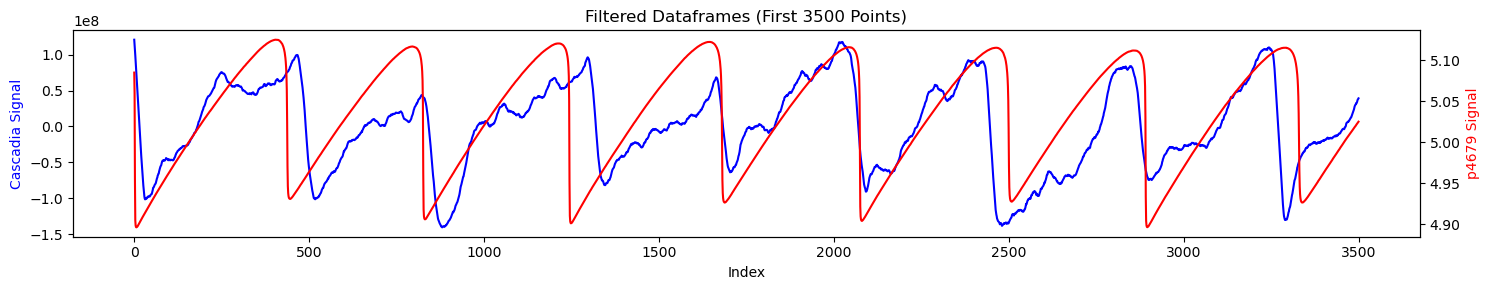

In [21]:
p4679_downsampling_factor = 13

df_cascadia_filtered = moving_average_causal_filter(df_cascadia, 30, 1)
df_p4679_filtered = moving_average_causal_filter(df_p4679, p4679_downsampling_factor, p4679_downsampling_factor)

fig, ax1 = plt.subplots(figsize=(15, 3))

# Plot dataframe on the left y-axis without legend
df_cascadia_filtered[:3500].plot(ax=ax1, y='signal', color='blue', legend=False)
ax1.set_xlabel('Index')
ax1.set_ylabel('Cascadia Signal', color='blue')
ax1.grid(False)

# Create a secondary y-axis for p4679 dataframe without legend
ax2 = ax1.twinx()
df_p4679_filtered[:3500].plot(ax=ax2, y='signal', color='red', legend=False)
ax2.set_ylabel('p4679 Signal', color='red')
ax2.grid(False)

plt.title('Filtered Dataframes (First 3500 Points)')
plt.tight_layout()
plt.show()

## Comment: 60 step smoothing for Cascadia - we assume that it is not possible to distinguish signal from noise at a resolution of less than 60 days, and the noise has a mean of 0

In [13]:
def find_peak_indices(data, threshold = 150):
    peak_indices = []
    for i in range(threshold, len(data) - threshold):
        if data[i] > max(data[i - threshold : i]) and data[i] >= max(
            data[i + 1 : i + threshold]
        ):
            peak_indices.append(i)
    return peak_indices

In [14]:
# Call the find_peak_indices function to get the peak and trough indices
cascadia_peaks = find_peak_indices(df_cascadia_filtered["signal"], threshold = 150)
cascadia_troughs = find_peak_indices(-df_cascadia_filtered["signal"], threshold = 150)

df_cascadia_filtered["peaks"] = np.where(df_cascadia_filtered.index.isin(cascadia_peaks), df_cascadia_filtered["signal"], np.nan)
df_cascadia_filtered["troughs"] = np.where(df_cascadia_filtered.index.isin(cascadia_troughs), df_cascadia_filtered["signal"], np.nan)

# Call the find_peak_indices function to get the peak and trough indices
p4679_peaks = find_peak_indices(df_p4679_filtered["signal"], threshold = 150)
p4679_troughs = find_peak_indices(-df_p4679_filtered["signal"], threshold = 150)

df_p4679_filtered["peaks"] = np.where(df_p4679_filtered.index.isin(p4679_peaks), df_p4679_filtered["signal"], np.nan)
df_p4679_filtered["troughs"] = np.where(df_p4679_filtered.index.isin(p4679_troughs), df_p4679_filtered["signal"], np.nan)


In [15]:
# Plots the shear stress time series with peaks and troughs marked by crosses (red and green)

from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, output_notebook, show

output_notebook()

source = ColumnDataSource(df_p4679_filtered)

p = figure(
    width=1200,
    height=400,
    x_axis_label="Index",
    y_axis_label="Shear Stress",
    title="Shear Stress with Peaks and Troughs Marked",
)
p.line(x="index", y="signal", source=source)


# Add peaks with red x marks
p.cross(x="index", y="peaks", source=source, color="red", size=8)

# Add troughs with green x marks
p.cross(x="index", y="troughs", source=source, color="green", size=8)


show(p)

Loading BokehJS ...

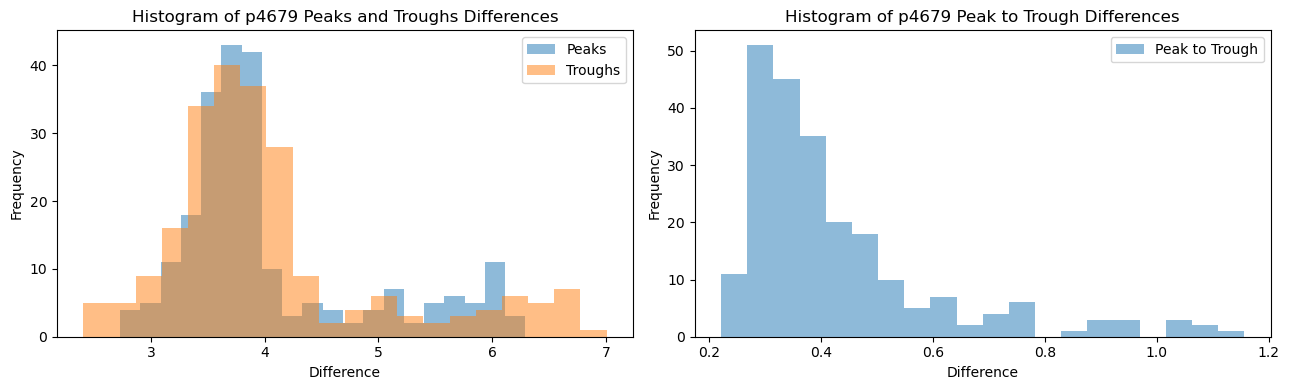

In [16]:
p4679_peaks_diff = np.diff(p4679_peaks) / (1000/p4679_downsampling_factor)
p4679_troughs_diff = np.diff(p4679_troughs) / (1000/p4679_downsampling_factor)
p4679_peak_to_trough = (np.array(p4679_troughs) - np.array(p4679_peaks)) / (1000/p4679_downsampling_factor)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# Plot the histogram of p4679_peaks_diff and p4679_troughs_diff on the first subplot
ax1.hist(p4679_peaks_diff, bins=20, alpha=0.5, label='Peaks')
ax1.hist(p4679_troughs_diff, bins=20, alpha=0.5, label='Troughs')
ax1.set_xlabel('Difference')
ax1.set_ylabel('Frequency')
ax1.set_title('Histogram of p4679 Peaks and Troughs Differences')
ax1.legend()

# Plot the histogram of p4679_peak_to_trough on the second subplot
ax2.hist(p4679_peak_to_trough, bins=20, alpha=0.5, label='Peak to Trough')
ax2.set_xlabel('Difference')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of p4679 Peak to Trough Differences')
ax2.legend()

plt.tight_layout()
plt.show()


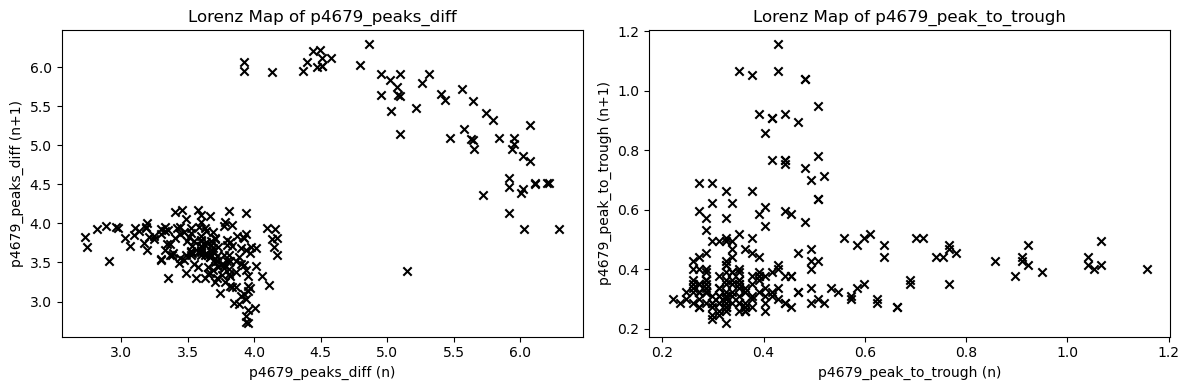

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the first Lorenz map with p4679_peaks_diff
ax1.scatter(p4679_peaks_diff[:-1], p4679_peaks_diff[1:], marker='x', color='black')
ax1.set_xlabel('p4679_peaks_diff (n)')
ax1.set_ylabel('p4679_peaks_diff (n+1)')
ax1.set_title('Lorenz Map of p4679_peaks_diff')

# Plot the second Lorenz map with p4679_peak_to_trough
ax2.scatter(p4679_peak_to_trough[:-1], p4679_peak_to_trough[1:], marker='x', color='black')
ax2.set_xlabel('p4679_peak_to_trough (n)')
ax2.set_ylabel('p4679_peak_to_trough (n+1)')
ax2.set_title('Lorenz Map of p4679_peak_to_trough')

plt.tight_layout()
plt.show()



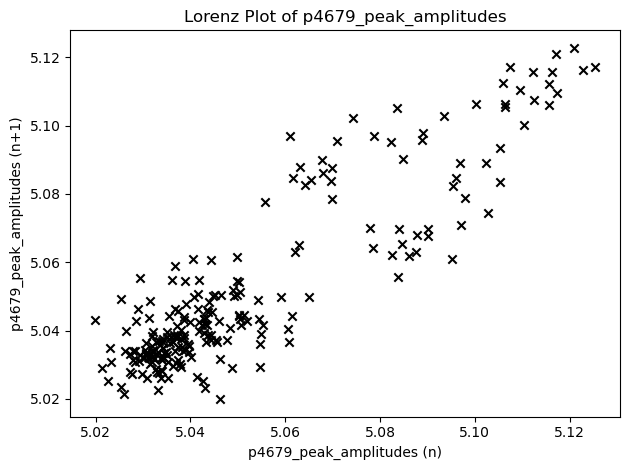

In [18]:
p4679_peak_amplitudes = np.array(df_p4679_filtered['signal'].iloc[p4679_peaks])

plt.scatter(p4679_peak_amplitudes[:-1], p4679_peak_amplitudes[1:], marker='x', color='black')
plt.xlabel('p4679_peak_amplitudes (n)')
plt.ylabel('p4679_peak_amplitudes (n+1)')
plt.title('Lorenz Plot of p4679_peak_amplitudes')
plt.tight_layout()
plt.show()


In [19]:
# Call the find_peak_indices function to get the peak and trough indices - takes ~1 minute to run on sci servers

# Calculate first derivative of shear stress
df_p4679_filtered["first_derivative"] = df_p4679_filtered["signal"].diff()

# Calculate second derivative of shear stress
df_p4679_filtered["second_derivative"] = df_p4679_filtered["first_derivative"].diff()

p4679_max_velocity_indices = find_peak_indices(-df_p4679_filtered["first_derivative"], threshold = 150)

df_p4679_filtered["max_velocity"] = np.where(df_p4679_filtered.index.isin(p4679_max_velocity_indices), df_p4679_filtered["first_derivative"], np.nan)

df_p4679_filtered.head()

output_notebook()

source = ColumnDataSource(df_p4679_filtered)

p = figure(
    width=1200,
    height=400,
    x_axis_label="index",
    y_axis_label="Velocity",
    title="Max Velocity Indices Marked",
)
p.line(x="index", y="first_derivative", source=source)

# Add peaks with red x marks
p.cross(x="index", y="max_velocity", source=source, color="black", size=8)

show(p)

Loading BokehJS ...

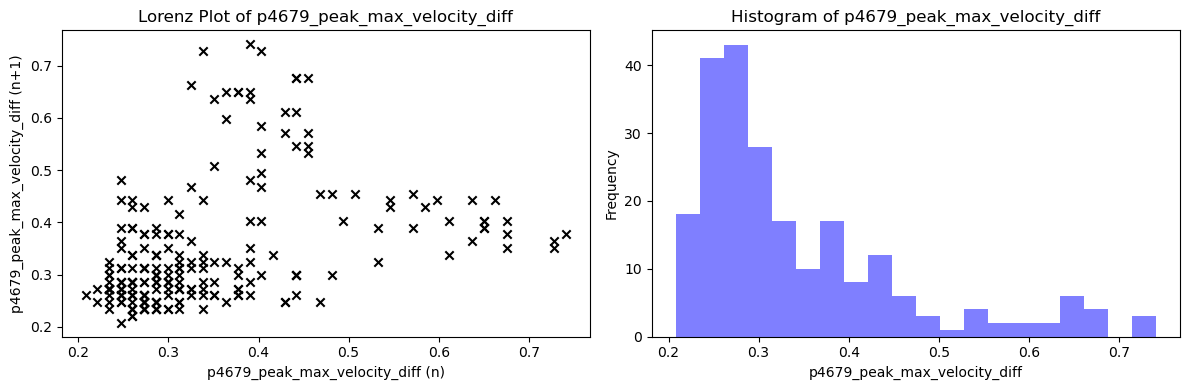

In [20]:
p4679_peak_max_velocity_diff = (np.array(p4679_max_velocity_indices) - np.array(p4679_peaks)) / (1000/p4679_downsampling_factor)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot the Lorenz plot on the first subplot
ax1.scatter(p4679_peak_max_velocity_diff[:-1], p4679_peak_max_velocity_diff[1:], marker='x', color='black')
ax1.set_xlabel('p4679_peak_max_velocity_diff (n)')
ax1.set_ylabel('p4679_peak_max_velocity_diff (n+1)')
ax1.set_title('Lorenz Plot of p4679_peak_max_velocity_diff')

# Plot the histogram on the second subplot
ax2.hist(p4679_peak_max_velocity_diff, bins=20, alpha=0.5, color='blue')
ax2.set_xlabel('p4679_peak_max_velocity_diff')
ax2.set_ylabel('Frequency')
ax2.set_title('Histogram of p4679_peak_max_velocity_diff')

plt.tight_layout()
plt.show()

### Looks like two clusters - what separates them?

- says not periodic or quasi periodic
- definitiono f quasi periodic - you have a frequency spectrum with a fininte number of peaks - these main frequencies, ratio betewen teh wto is an irrational number